<a href="https://colab.research.google.com/github/marcinwolter/DeepLearning_2020_private/blob/main/cwiczenia_4a_regression_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **A regression example**

Common type of machine learning problem is "regression", which consists of predicting a continuous value instead of a discrete label. For instance, predicting the temperature tomorrow, given meteorological data, or predicting the time that a software project will take to complete, given its specifications.



In [1]:

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt



**1-dimensional data**

In [2]:
def funct(x):
  return x*x*np.sin(x)+np.log(2*x)

size = 100
low=0
high=12
error=10

XX_train = np.random.uniform(low=low, high=high, size=size)
XX_test = np.random.uniform(low=low, high=high, size=size)
yy_train = funct(XX_train) + np.random.normal(0., error, size)
yy_test = funct(XX_test) + np.random.normal(0., error, size)

print(XX_train.shape, yy_train.shape)

(100,) (100,)


Plot the function and data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


<function matplotlib.pyplot.show>

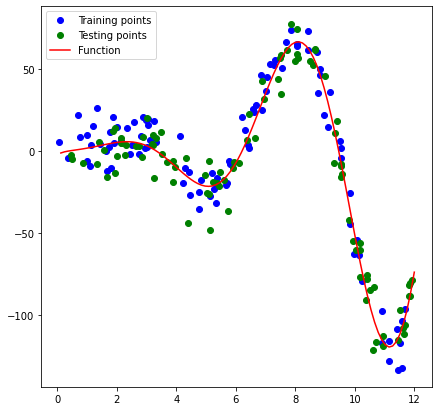

In [3]:
fig = plt.figure(figsize=(7,7))

plt.plot(XX_train,yy_train, 'o', color='blue', label='Training points')
plt.plot(XX_test,yy_test, 'o', color='green', label='Testing points')

points = np.linspace(low, high,num=100)
plt.plot(points, funct(points),  color='red', label='Function')
plt.legend()


plt.show


**Preparing the data**

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we will subtract the mean of the feature and divide by the standard deviation, so that the feature will be centered around 0 and will have a unit standard deviation. This is easily done in Numpy:


In [4]:
mean = XX_train.mean(axis=0)
XX_train_n = XX_train-mean
std = XX_train_n.std(axis=0)
XX_train_n /= std

XX_test_n = XX_test - mean
XX_test_n /= std

meany = yy_train.mean(axis=0)
yy_train_n = yy_train - meany
stdy = yy_train_n.std(axis=0)
yy_train_n /= stdy

yy_test_n = yy_test - meany
yy_test_n /= stdy



#XX_train_n = XX_train_n.reshape((len(XX_train_n),1))
#XX_test_n  = XX_test_n.reshape((len(XX_test_n),1))


In [5]:
! pip install optuna

import optuna

     |████████████████████████████████| 266kB 9.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163kB 10.4MB/s 
     |████████████████████████████████| 81kB 7.2MB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 112kB 16.5MB/s 
     |████████████████████████████████| 133kB 16.0MB/s 
  Created wheel for optuna: filename=optuna-2.3.0-cp36-none-any.whl size=359761 sha256=5c9086f9ce222ec8bfd696f251c39916947f978758c8c158ca1f48409dcf2e41
  Stored in directory: /root/.cache/pip/wheels/fa/91/19/64b0ec6b964f89c0695a9dc6db6f851d0b54c5381a5c9cadfb
Successfully built optuna
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13700 sha256=9d64b4e186d26cbbffb941434305f7182b0bbca72902f4eb888659ebc233e372
  Stored in directory: /root/.cache/pip/whe

Define objective

In [6]:
def objective(trial):


    units = int(trial.suggest_discrete_uniform("units1", 32,1024,1))
    dropout = trial.suggest_uniform('dropout1', .00,.50)
    act = trial.suggest_categorical('activation', ['relu','sigmoid','linear'])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    #epochs = int(trial.suggest_discrete_uniform('epochs', 10,100,1))
    epochs = 400

    model0 = Sequential(name='network')
    model0.add(Dense(units, input_shape = (1,), activation = act))
    model0.add(Dropout(dropout))
    model0.add(Dense(units, activation = act))
    model0.add(Dropout(dropout))
    model0.add(Dense(1,activation='linear'))

    #sgd0 = optimizers.SGD(lr = 0.01)    # stochastic gradient descent optimizer

    #  early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    model0.compile(optimizer = optimizers.Adam(lr=lr), loss = 'mean_squared_error', metrics = ['mse'])    # for regression problems, mean squared error (MSE) is often employed
    history = model0.fit(XX_train_n, yy_train_n, batch_size = 128, epochs = epochs, validation_data=(XX_test_n, yy_test_n), verbose = 0 , callbacks=[es])


    # Evaluate the model accuracy on the validation set.
    score = model0.evaluate(XX_test_n, yy_test_n, verbose=0)
    return score[1]

# Find the best parameters

In [7]:


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=600)


[I 2020-12-07 21:36:43,640] A new study created in memory with name: no-name-be63c2f7-8fe3-413c-a47d-b4a2a8ff64ba
[I 2020-12-07 21:36:52,816] Trial 0 finished with value: 0.8855509161949158 and parameters: {'units1': 860.0, 'dropout1': 0.0011227105337235366, 'activation': 'linear', 'lr': 0.0023557108356561545}. Best is trial 0 with value: 0.8855509161949158.


Epoch 00089: early stopping


[I 2020-12-07 21:36:54,664] Trial 1 finished with value: 0.87865149974823 and parameters: {'units1': 974.0, 'dropout1': 0.08409805046024788, 'activation': 'linear', 'lr': 0.0025683040220224975}. Best is trial 1 with value: 0.87865149974823.


Epoch 00085: early stopping


[I 2020-12-07 21:36:56,650] Trial 2 finished with value: 0.8752909898757935 and parameters: {'units1': 127.0, 'dropout1': 0.261655956616073, 'activation': 'linear', 'lr': 0.07623202227425045}. Best is trial 2 with value: 0.8752909898757935.


Epoch 00087: early stopping


[I 2020-12-07 21:37:00,627] Trial 3 finished with value: 0.13214276731014252 and parameters: {'units1': 900.0, 'dropout1': 0.4134867914176291, 'activation': 'relu', 'lr': 0.006206122362739586}. Best is trial 3 with value: 0.13214276731014252.


Epoch 00208: early stopping


[I 2020-12-07 21:37:02,644] Trial 4 finished with value: 0.8820460438728333 and parameters: {'units1': 932.0, 'dropout1': 0.15933565065615285, 'activation': 'linear', 'lr': 0.0034992159332792538}. Best is trial 3 with value: 0.13214276731014252.


Epoch 00096: early stopping


[I 2020-12-07 21:37:07,574] Trial 5 finished with value: 0.1277441382408142 and parameters: {'units1': 82.0, 'dropout1': 0.49488368026527974, 'activation': 'relu', 'lr': 0.003097975647675846}. Best is trial 5 with value: 0.1277441382408142.


Epoch 00270: early stopping


[I 2020-12-07 21:37:09,706] Trial 6 finished with value: 0.8833364844322205 and parameters: {'units1': 917.0, 'dropout1': 0.22068735397914496, 'activation': 'linear', 'lr': 1.578058605959736e-05}. Best is trial 5 with value: 0.1277441382408142.


Epoch 00092: early stopping


[I 2020-12-07 21:37:16,535] Trial 7 finished with value: 0.3701380491256714 and parameters: {'units1': 905.0, 'dropout1': 0.00386550959432741, 'activation': 'relu', 'lr': 2.734017996823747e-05}. Best is trial 5 with value: 0.1277441382408142.
[I 2020-12-07 21:37:19,346] Trial 8 finished with value: 1.1605126857757568 and parameters: {'units1': 725.0, 'dropout1': 0.10124584758818012, 'activation': 'sigmoid', 'lr': 0.0348807777776026}. Best is trial 5 with value: 0.1277441382408142.


Epoch 00136: early stopping


[I 2020-12-07 21:37:26,247] Trial 9 finished with value: 0.12148640304803848 and parameters: {'units1': 620.0, 'dropout1': 0.3582923994708019, 'activation': 'relu', 'lr': 0.0009785848217084548}. Best is trial 9 with value: 0.12148640304803848.
[I 2020-12-07 21:37:33,118] Trial 10 finished with value: 0.1885966807603836 and parameters: {'units1': 368.0, 'dropout1': 0.35654957677038124, 'activation': 'relu', 'lr': 0.00011012056981719164}. Best is trial 9 with value: 0.12148640304803848.
[I 2020-12-07 21:37:37,591] Trial 11 finished with value: 0.2038126140832901 and parameters: {'units1': 513.0, 'dropout1': 0.48111204260410767, 'activation': 'relu', 'lr': 0.00023900402060451434}. Best is trial 9 with value: 0.12148640304803848.


Epoch 00239: early stopping


[I 2020-12-07 21:37:44,507] Trial 12 finished with value: 0.19659218192100525 and parameters: {'units1': 116.0, 'dropout1': 0.49437482264661736, 'activation': 'relu', 'lr': 0.0003463314439412061}. Best is trial 9 with value: 0.12148640304803848.
[I 2020-12-07 21:37:45,953] Trial 13 finished with value: 1.1911062002182007 and parameters: {'units1': 326.0, 'dropout1': 0.3462408527591209, 'activation': 'sigmoid', 'lr': 0.01844078712575701}. Best is trial 9 with value: 0.12148640304803848.


Epoch 00057: early stopping


[I 2020-12-07 21:37:52,744] Trial 14 finished with value: 0.1313047558069229 and parameters: {'units1': 646.0, 'dropout1': 0.4214451485815013, 'activation': 'relu', 'lr': 0.000799931106256239}. Best is trial 9 with value: 0.12148640304803848.
[I 2020-12-07 21:37:55,653] Trial 15 finished with value: 0.13313239812850952 and parameters: {'units1': 492.0, 'dropout1': 0.28999121759410557, 'activation': 'relu', 'lr': 0.011180532528899393}. Best is trial 9 with value: 0.12148640304803848.


Epoch 00151: early stopping


[I 2020-12-07 21:38:02,156] Trial 16 finished with value: 0.12279638648033142 and parameters: {'units1': 692.0, 'dropout1': 0.42816491453943467, 'activation': 'relu', 'lr': 0.0010042720357573659}. Best is trial 9 with value: 0.12148640304803848.


Epoch 00355: early stopping


[I 2020-12-07 21:38:05,816] Trial 17 finished with value: 0.914879322052002 and parameters: {'units1': 698.0, 'dropout1': 0.40380207682548586, 'activation': 'sigmoid', 'lr': 0.0009111397782453333}. Best is trial 9 with value: 0.12148640304803848.


Epoch 00201: early stopping


[I 2020-12-07 21:38:12,669] Trial 18 finished with value: 0.20817366242408752 and parameters: {'units1': 615.0, 'dropout1': 0.32592054782985347, 'activation': 'relu', 'lr': 6.0995611263001934e-05}. Best is trial 9 with value: 0.12148640304803848.
[I 2020-12-07 21:38:19,284] Trial 19 finished with value: 0.12994815409183502 and parameters: {'units1': 776.0, 'dropout1': 0.4576305526345347, 'activation': 'relu', 'lr': 0.0006295010598293707}. Best is trial 9 with value: 0.12148640304803848.


Epoch 00381: early stopping


[I 2020-12-07 21:38:24,328] Trial 20 finished with value: 0.21278955042362213 and parameters: {'units1': 399.0, 'dropout1': 0.3798350189971809, 'activation': 'relu', 'lr': 0.00020027213484616511}. Best is trial 9 with value: 0.12148640304803848.


Epoch 00274: early stopping


[I 2020-12-07 21:38:30,191] Trial 21 finished with value: 0.11819648742675781 and parameters: {'units1': 264.0, 'dropout1': 0.4993122854765654, 'activation': 'relu', 'lr': 0.001674655303445746}. Best is trial 21 with value: 0.11819648742675781.


Epoch 00351: early stopping


[I 2020-12-07 21:38:34,450] Trial 22 finished with value: 0.13142350316047668 and parameters: {'units1': 282.0, 'dropout1': 0.45317727284037035, 'activation': 'relu', 'lr': 0.0013489450358421735}. Best is trial 21 with value: 0.11819648742675781.


Epoch 00230: early stopping


[I 2020-12-07 21:38:38,418] Trial 23 finished with value: 0.203222393989563 and parameters: {'units1': 224.0, 'dropout1': 0.31220451563321044, 'activation': 'relu', 'lr': 0.00045762886097334716}. Best is trial 21 with value: 0.11819648742675781.


Epoch 00210: early stopping


[I 2020-12-07 21:38:45,149] Trial 24 finished with value: 0.12352428585290909 and parameters: {'units1': 609.0, 'dropout1': 0.4438695984945693, 'activation': 'relu', 'lr': 0.001554981317173618}. Best is trial 21 with value: 0.11819648742675781.


Epoch 00381: early stopping


[I 2020-12-07 21:38:49,150] Trial 25 finished with value: 0.15041117370128632 and parameters: {'units1': 451.0, 'dropout1': 0.39043604692300204, 'activation': 'relu', 'lr': 0.009062261675847855}. Best is trial 21 with value: 0.11819648742675781.


Epoch 00216: early stopping


[I 2020-12-07 21:38:55,402] Trial 26 finished with value: 0.9230302572250366 and parameters: {'units1': 799.0, 'dropout1': 0.2176315113196568, 'activation': 'sigmoid', 'lr': 0.0001922932578597523}. Best is trial 21 with value: 0.11819648742675781.


Epoch 00370: early stopping


[I 2020-12-07 21:39:02,410] Trial 27 finished with value: 0.17887327075004578 and parameters: {'units1': 567.0, 'dropout1': 0.3655123599301093, 'activation': 'relu', 'lr': 8.215798348484557e-05}. Best is trial 21 with value: 0.11819648742675781.
[I 2020-12-07 21:39:06,782] Trial 28 finished with value: 0.11341741681098938 and parameters: {'units1': 690.0, 'dropout1': 0.4391564300966669, 'activation': 'relu', 'lr': 0.005108990791617959}. Best is trial 28 with value: 0.11341741681098938.


Epoch 00243: early stopping


[I 2020-12-07 21:39:10,287] Trial 29 finished with value: 0.12440767139196396 and parameters: {'units1': 821.0, 'dropout1': 0.4741356649245813, 'activation': 'relu', 'lr': 0.005079539095965081}. Best is trial 28 with value: 0.11341741681098938.


Epoch 00182: early stopping


[I 2020-12-07 21:39:12,792] Trial 30 finished with value: 0.14349304139614105 and parameters: {'units1': 554.0, 'dropout1': 0.49848756959766155, 'activation': 'relu', 'lr': 0.034289248132502885}. Best is trial 28 with value: 0.11341741681098938.


Epoch 00119: early stopping


[I 2020-12-07 21:39:18,485] Trial 31 finished with value: 0.12619170546531677 and parameters: {'units1': 678.0, 'dropout1': 0.4321774385909506, 'activation': 'relu', 'lr': 0.0015835580058244998}. Best is trial 28 with value: 0.11341741681098938.


Epoch 00329: early stopping


[I 2020-12-07 21:39:23,290] Trial 32 finished with value: 0.12937113642692566 and parameters: {'units1': 761.0, 'dropout1': 0.41021883265091225, 'activation': 'relu', 'lr': 0.0021778888571673686}. Best is trial 28 with value: 0.11341741681098938.


Epoch 00257: early stopping


[I 2020-12-07 21:39:25,256] Trial 33 finished with value: 0.8864176273345947 and parameters: {'units1': 721.0, 'dropout1': 0.44410472339554874, 'activation': 'linear', 'lr': 0.004678013680888684}. Best is trial 28 with value: 0.11341741681098938.


Epoch 00093: early stopping


[I 2020-12-07 21:39:31,419] Trial 34 finished with value: 0.12725457549095154 and parameters: {'units1': 205.0, 'dropout1': 0.26771999191974505, 'activation': 'relu', 'lr': 0.002262466174827674}. Best is trial 28 with value: 0.11341741681098938.


Epoch 00349: early stopping


[I 2020-12-07 21:39:38,210] Trial 35 finished with value: 0.1422034502029419 and parameters: {'units1': 463.0, 'dropout1': 0.32599654059943106, 'activation': 'relu', 'lr': 0.0006390844269448368}. Best is trial 28 with value: 0.11341741681098938.
[I 2020-12-07 21:39:39,653] Trial 36 finished with value: 0.9509896636009216 and parameters: {'units1': 860.0, 'dropout1': 0.471458367488317, 'activation': 'linear', 'lr': 0.009742910642387416}. Best is trial 28 with value: 0.11341741681098938.


Epoch 00061: early stopping


[I 2020-12-07 21:39:44,686] Trial 37 finished with value: 0.10377518832683563 and parameters: {'units1': 996.0, 'dropout1': 0.39185699402470225, 'activation': 'relu', 'lr': 0.0032792061437709337}. Best is trial 37 with value: 0.10377518832683563.


Epoch 00278: early stopping


[I 2020-12-07 21:39:49,164] Trial 38 finished with value: 0.11300091445446014 and parameters: {'units1': 1012.0, 'dropout1': 0.3865561908529652, 'activation': 'relu', 'lr': 0.0034386655325889743}. Best is trial 37 with value: 0.10377518832683563.


Epoch 00254: early stopping


[I 2020-12-07 21:39:51,714] Trial 39 finished with value: 0.8847713470458984 and parameters: {'units1': 1007.0, 'dropout1': 0.392685979675562, 'activation': 'linear', 'lr': 0.017470673042521215}. Best is trial 37 with value: 0.10377518832683563.


Epoch 00111: early stopping


[I 2020-12-07 21:39:58,982] Trial 40 finished with value: 0.10127444565296173 and parameters: {'units1': 956.0, 'dropout1': 0.16845298111202983, 'activation': 'relu', 'lr': 0.003848032834680409}. Best is trial 40 with value: 0.10127444565296173.
[I 2020-12-07 21:40:05,977] Trial 41 finished with value: 0.08402249217033386 and parameters: {'units1': 981.0, 'dropout1': 0.1493669552618994, 'activation': 'relu', 'lr': 0.0032399239504298408}. Best is trial 41 with value: 0.08402249217033386.
[I 2020-12-07 21:40:11,750] Trial 42 finished with value: 0.0972033217549324 and parameters: {'units1': 968.0, 'dropout1': 0.14233138105375975, 'activation': 'relu', 'lr': 0.003531500638508576}. Best is trial 41 with value: 0.08402249217033386.


Epoch 00321: early stopping


[I 2020-12-07 21:40:18,516] Trial 43 finished with value: 0.11217442154884338 and parameters: {'units1': 966.0, 'dropout1': 0.12285003085694449, 'activation': 'relu', 'lr': 0.003225452499158427}. Best is trial 41 with value: 0.08402249217033386.


Epoch 00388: early stopping


[I 2020-12-07 21:40:23,229] Trial 44 finished with value: 0.09200707077980042 and parameters: {'units1': 960.0, 'dropout1': 0.1273852469781347, 'activation': 'relu', 'lr': 0.007333106249864187}. Best is trial 41 with value: 0.08402249217033386.


Epoch 00270: early stopping


[I 2020-12-07 21:40:27,797] Trial 45 finished with value: 0.08803041279315948 and parameters: {'units1': 964.0, 'dropout1': 0.052959305217757074, 'activation': 'relu', 'lr': 0.007125199079782747}. Best is trial 41 with value: 0.08402249217033386.


Epoch 00258: early stopping


[I 2020-12-07 21:40:29,712] Trial 46 finished with value: 1.1730495691299438 and parameters: {'units1': 951.0, 'dropout1': 0.05634928992882685, 'activation': 'sigmoid', 'lr': 0.0074620246571538255}. Best is trial 41 with value: 0.08402249217033386.


Epoch 00089: early stopping


[I 2020-12-07 21:40:31,636] Trial 47 finished with value: 0.06982994824647903 and parameters: {'units1': 888.0, 'dropout1': 0.1677799951858065, 'activation': 'relu', 'lr': 0.02546996800378082}. Best is trial 47 with value: 0.06982994824647903.


Epoch 00089: early stopping


[I 2020-12-07 21:40:33,827] Trial 48 finished with value: 0.430825799703598 and parameters: {'units1': 882.0, 'dropout1': 0.026057063681213938, 'activation': 'relu', 'lr': 0.09109636885623408}. Best is trial 47 with value: 0.06982994824647903.


Epoch 00108: early stopping


[I 2020-12-07 21:40:37,010] Trial 49 finished with value: 0.061933744698762894 and parameters: {'units1': 856.0, 'dropout1': 0.15376535589167437, 'activation': 'relu', 'lr': 0.046800213904430656}. Best is trial 49 with value: 0.061933744698762894.


Epoch 00175: early stopping


[I 2020-12-07 21:40:39,678] Trial 50 finished with value: 0.08723023533821106 and parameters: {'units1': 850.0, 'dropout1': 0.19221570317070383, 'activation': 'relu', 'lr': 0.03463888264566262}. Best is trial 49 with value: 0.061933744698762894.


Epoch 00120: early stopping


[I 2020-12-07 21:40:42,743] Trial 51 finished with value: 0.08308016508817673 and parameters: {'units1': 831.0, 'dropout1': 0.17579122398912772, 'activation': 'relu', 'lr': 0.03774302712860951}. Best is trial 49 with value: 0.061933744698762894.


Epoch 00153: early stopping


[I 2020-12-07 21:40:47,403] Trial 52 finished with value: 0.06941935420036316 and parameters: {'units1': 853.0, 'dropout1': 0.18765403669488426, 'activation': 'relu', 'lr': 0.051208293196967535}. Best is trial 49 with value: 0.061933744698762894.


Epoch 00231: early stopping


[I 2020-12-07 21:40:51,111] Trial 53 finished with value: 0.09175147861242294 and parameters: {'units1': 829.0, 'dropout1': 0.19415576845502558, 'activation': 'relu', 'lr': 0.06276721333572048}. Best is trial 49 with value: 0.061933744698762894.


Epoch 00183: early stopping


[I 2020-12-07 21:40:55,531] Trial 54 finished with value: 0.06825213879346848 and parameters: {'units1': 907.0, 'dropout1': 0.17819800831850513, 'activation': 'relu', 'lr': 0.04997163454583474}. Best is trial 49 with value: 0.061933744698762894.


Epoch 00227: early stopping


[I 2020-12-07 21:40:59,016] Trial 55 finished with value: 0.13639499247074127 and parameters: {'units1': 905.0, 'dropout1': 0.23379681735697716, 'activation': 'relu', 'lr': 0.055227557320778074}. Best is trial 49 with value: 0.061933744698762894.


Epoch 00191: early stopping


[I 2020-12-07 21:41:03,048] Trial 56 finished with value: 0.07106391340494156 and parameters: {'units1': 917.0, 'dropout1': 0.1694764952943193, 'activation': 'relu', 'lr': 0.022632658419833484}. Best is trial 49 with value: 0.061933744698762894.


Epoch 00220: early stopping


[I 2020-12-07 21:41:05,615] Trial 57 finished with value: 1.142288327217102 and parameters: {'units1': 911.0, 'dropout1': 0.17262344508479552, 'activation': 'sigmoid', 'lr': 0.021070951534206923}. Best is trial 49 with value: 0.061933744698762894.


Epoch 00121: early stopping


[I 2020-12-07 21:41:09,317] Trial 58 finished with value: 0.052687980234622955 and parameters: {'units1': 780.0, 'dropout1': 0.10464358268107507, 'activation': 'relu', 'lr': 0.047228164330655104}. Best is trial 58 with value: 0.052687980234622955.


Epoch 00199: early stopping


[I 2020-12-07 21:41:11,492] Trial 59 finished with value: 0.8909618258476257 and parameters: {'units1': 763.0, 'dropout1': 0.09086914126828557, 'activation': 'linear', 'lr': 0.02408071624940114}. Best is trial 58 with value: 0.052687980234622955.


Epoch 00110: early stopping


[I 2020-12-07 21:41:18,417] Trial 60 finished with value: 0.07313071191310883 and parameters: {'units1': 888.0, 'dropout1': 0.1055462891691336, 'activation': 'relu', 'lr': 0.09729791453312532}. Best is trial 58 with value: 0.052687980234622955.
[I 2020-12-07 21:41:23,519] Trial 61 finished with value: 0.3012789189815521 and parameters: {'units1': 865.0, 'dropout1': 0.10657024714978261, 'activation': 'relu', 'lr': 0.09856835397337425}. Best is trial 58 with value: 0.052687980234622955.


Epoch 00295: early stopping


[I 2020-12-07 21:41:26,450] Trial 62 finished with value: 0.10065130889415741 and parameters: {'units1': 926.0, 'dropout1': 0.2100312468413031, 'activation': 'relu', 'lr': 0.04932859935181504}. Best is trial 58 with value: 0.052687980234622955.


Epoch 00140: early stopping


[I 2020-12-07 21:41:32,059] Trial 63 finished with value: 0.0647563561797142 and parameters: {'units1': 792.0, 'dropout1': 0.1337575369241558, 'activation': 'relu', 'lr': 0.06573802848291047}. Best is trial 58 with value: 0.052687980234622955.


Epoch 00290: early stopping


[I 2020-12-07 21:41:37,480] Trial 64 finished with value: 0.0930904895067215 and parameters: {'units1': 804.0, 'dropout1': 0.06772262189172727, 'activation': 'relu', 'lr': 0.0717581820166539}. Best is trial 58 with value: 0.052687980234622955.


Epoch 00315: early stopping


[I 2020-12-07 21:41:39,958] Trial 65 finished with value: 0.0946737751364708 and parameters: {'units1': 806.0, 'dropout1': 0.13142474990693354, 'activation': 'relu', 'lr': 0.01558173507846649}. Best is trial 58 with value: 0.052687980234622955.


Epoch 00125: early stopping


[I 2020-12-07 21:41:43,269] Trial 66 finished with value: 0.1138693168759346 and parameters: {'units1': 735.0, 'dropout1': 0.152311748916953, 'activation': 'relu', 'lr': 0.013380728589502603}. Best is trial 58 with value: 0.052687980234622955.


Epoch 00175: early stopping


[I 2020-12-07 21:41:45,585] Trial 67 finished with value: 0.09255152940750122 and parameters: {'units1': 869.0, 'dropout1': 0.19164648738437223, 'activation': 'relu', 'lr': 0.025662761916671523}. Best is trial 58 with value: 0.052687980234622955.


Epoch 00116: early stopping


[I 2020-12-07 21:41:48,379] Trial 68 finished with value: 0.10254959762096405 and parameters: {'units1': 776.0, 'dropout1': 0.242640759041271, 'activation': 'relu', 'lr': 0.04517981304091417}. Best is trial 58 with value: 0.052687980234622955.


Epoch 00143: early stopping


[I 2020-12-07 21:41:51,578] Trial 69 finished with value: 0.06867838650941849 and parameters: {'units1': 923.0, 'dropout1': 0.1164852355292674, 'activation': 'relu', 'lr': 0.02569835820066069}. Best is trial 58 with value: 0.052687980234622955.


Epoch 00170: early stopping


[I 2020-12-07 21:41:57,575] Trial 70 finished with value: 0.08838213235139847 and parameters: {'units1': 738.0, 'dropout1': 0.07188579435368771, 'activation': 'relu', 'lr': 0.07813599286313205}. Best is trial 58 with value: 0.052687980234622955.


Epoch 00338: early stopping


[I 2020-12-07 21:42:00,867] Trial 71 finished with value: 0.05926087871193886 and parameters: {'units1': 919.0, 'dropout1': 0.1179880695074298, 'activation': 'relu', 'lr': 0.027991313422900007}. Best is trial 58 with value: 0.052687980234622955.


Epoch 00169: early stopping


[I 2020-12-07 21:42:03,482] Trial 72 finished with value: 0.07182934880256653 and parameters: {'units1': 840.0, 'dropout1': 0.12233445244583718, 'activation': 'relu', 'lr': 0.028389273958142613}. Best is trial 58 with value: 0.052687980234622955.


Epoch 00132: early stopping


[I 2020-12-07 21:42:06,308] Trial 73 finished with value: 0.05869043245911598 and parameters: {'units1': 936.0, 'dropout1': 0.09053869480367724, 'activation': 'relu', 'lr': 0.04055275705100652}. Best is trial 58 with value: 0.052687980234622955.


Epoch 00150: early stopping


[I 2020-12-07 21:42:09,979] Trial 74 finished with value: 0.07291799783706665 and parameters: {'units1': 801.0, 'dropout1': 0.11025883410342874, 'activation': 'relu', 'lr': 0.05084058687027194}. Best is trial 58 with value: 0.052687980234622955.


Epoch 00201: early stopping


[I 2020-12-07 21:42:12,663] Trial 75 finished with value: 0.053390178829431534 and parameters: {'units1': 935.0, 'dropout1': 0.07967229711985496, 'activation': 'relu', 'lr': 0.039836201088104414}. Best is trial 58 with value: 0.052687980234622955.


Epoch 00114: early stopping


[I 2020-12-07 21:42:15,628] Trial 76 finished with value: 0.051513124257326126 and parameters: {'units1': 1015.0, 'dropout1': 0.0886200210100759, 'activation': 'relu', 'lr': 0.037054463922947034}. Best is trial 76 with value: 0.051513124257326126.


Epoch 00152: early stopping


[I 2020-12-07 21:42:18,261] Trial 77 finished with value: 1.1676400899887085 and parameters: {'units1': 1003.0, 'dropout1': 0.030302720928377935, 'activation': 'sigmoid', 'lr': 0.03674672486129233}. Best is trial 76 with value: 0.051513124257326126.


Epoch 00139: early stopping


[I 2020-12-07 21:42:24,408] Trial 78 finished with value: 0.05373438447713852 and parameters: {'units1': 1024.0, 'dropout1': 0.08845309857465172, 'activation': 'relu', 'lr': 0.06756395161892538}. Best is trial 76 with value: 0.051513124257326126.


Epoch 00370: early stopping


[I 2020-12-07 21:42:27,586] Trial 79 finished with value: 0.0895550549030304 and parameters: {'units1': 986.0, 'dropout1': 0.0862160584101742, 'activation': 'relu', 'lr': 0.0120686696968057}. Best is trial 76 with value: 0.051513124257326126.


Epoch 00166: early stopping


[I 2020-12-07 21:42:34,239] Trial 80 finished with value: 0.0943022221326828 and parameters: {'units1': 1016.0, 'dropout1': 0.043280277983954105, 'activation': 'relu', 'lr': 0.07238609824022879}. Best is trial 76 with value: 0.051513124257326126.


Epoch 00392: early stopping


[I 2020-12-07 21:42:38,510] Trial 81 finished with value: 0.056348767131567 and parameters: {'units1': 1024.0, 'dropout1': 0.0939451953173261, 'activation': 'relu', 'lr': 0.039517543196529066}. Best is trial 76 with value: 0.051513124257326126.


Epoch 00234: early stopping


[I 2020-12-07 21:42:44,441] Trial 82 finished with value: 0.05681418254971504 and parameters: {'units1': 945.0, 'dropout1': 0.073941896421539, 'activation': 'relu', 'lr': 0.04138823263762952}. Best is trial 76 with value: 0.051513124257326126.


Epoch 00341: early stopping


[I 2020-12-07 21:42:47,579] Trial 83 finished with value: 0.051630038768053055 and parameters: {'units1': 944.0, 'dropout1': 0.001678762535201106, 'activation': 'relu', 'lr': 0.037658318314635064}. Best is trial 76 with value: 0.051513124257326126.


Epoch 00165: early stopping


[I 2020-12-07 21:42:50,542] Trial 84 finished with value: 0.04843929409980774 and parameters: {'units1': 1020.0, 'dropout1': 0.018587642039695165, 'activation': 'relu', 'lr': 0.03062204612528448}. Best is trial 84 with value: 0.04843929409980774.


Epoch 00150: early stopping


[I 2020-12-07 21:42:53,017] Trial 85 finished with value: 0.057795677334070206 and parameters: {'units1': 1022.0, 'dropout1': 0.00853366778961005, 'activation': 'relu', 'lr': 0.017519649257715427}. Best is trial 84 with value: 0.04843929409980774.


Epoch 00127: early stopping


[I 2020-12-07 21:42:56,028] Trial 86 finished with value: 0.061536021530628204 and parameters: {'units1': 1012.0, 'dropout1': 0.009285911216637258, 'activation': 'relu', 'lr': 0.017186127936068406}. Best is trial 84 with value: 0.04843929409980774.


Epoch 00159: early stopping


[I 2020-12-07 21:42:58,667] Trial 87 finished with value: 0.8782777190208435 and parameters: {'units1': 1022.0, 'dropout1': 0.00041344079766329755, 'activation': 'linear', 'lr': 0.03223333480851057}. Best is trial 84 with value: 0.04843929409980774.


Epoch 00133: early stopping


[I 2020-12-07 21:43:01,888] Trial 88 finished with value: 0.09445903450250626 and parameters: {'units1': 987.0, 'dropout1': 0.013339721942938358, 'activation': 'relu', 'lr': 0.0856460645067548}. Best is trial 84 with value: 0.04843929409980774.


Epoch 00135: early stopping


[I 2020-12-07 21:43:08,140] Trial 89 finished with value: 0.052170731127262115 and parameters: {'units1': 939.0, 'dropout1': 0.06995628260823657, 'activation': 'relu', 'lr': 0.06085423633454443}. Best is trial 84 with value: 0.04843929409980774.


Epoch 00358: early stopping


[I 2020-12-07 21:43:12,643] Trial 90 finished with value: 0.06476099789142609 and parameters: {'units1': 946.0, 'dropout1': 0.07576662653012033, 'activation': 'relu', 'lr': 0.06155652996981761}. Best is trial 84 with value: 0.04843929409980774.


Epoch 00238: early stopping


[I 2020-12-07 21:43:14,842] Trial 91 finished with value: 0.07737302035093307 and parameters: {'units1': 983.0, 'dropout1': 0.04187801648016546, 'activation': 'relu', 'lr': 0.019499695343016998}. Best is trial 84 with value: 0.04843929409980774.


Epoch 00109: early stopping


[I 2020-12-07 21:43:18,351] Trial 92 finished with value: 0.08273961395025253 and parameters: {'units1': 1024.0, 'dropout1': 0.06181006065914828, 'activation': 'relu', 'lr': 0.03962012726189647}. Best is trial 84 with value: 0.04843929409980774.


Epoch 00189: early stopping


[I 2020-12-07 21:43:20,979] Trial 93 finished with value: 0.05352405458688736 and parameters: {'units1': 1024.0, 'dropout1': 0.022648974094188618, 'activation': 'relu', 'lr': 0.03403580685052219}. Best is trial 84 with value: 0.04843929409980774.


Epoch 00128: early stopping


[I 2020-12-07 21:43:23,664] Trial 94 finished with value: 0.052366580814123154 and parameters: {'units1': 940.0, 'dropout1': 0.023547915009106003, 'activation': 'relu', 'lr': 0.029989552565771987}. Best is trial 84 with value: 0.04843929409980774.


Epoch 00126: early stopping


[I 2020-12-07 21:43:27,341] Trial 95 finished with value: 0.06921614706516266 and parameters: {'units1': 972.0, 'dropout1': 0.024079836880391305, 'activation': 'relu', 'lr': 0.02952845751029881}. Best is trial 84 with value: 0.04843929409980774.


Epoch 00198: early stopping


[I 2020-12-07 21:43:31,419] Trial 96 finished with value: 0.11634554713964462 and parameters: {'units1': 48.0, 'dropout1': 0.04420925289945833, 'activation': 'relu', 'lr': 0.0136214732865625}. Best is trial 84 with value: 0.04843929409980774.


Epoch 00224: early stopping


[I 2020-12-07 21:43:38,310] Trial 97 finished with value: 0.6730735301971436 and parameters: {'units1': 991.0, 'dropout1': 0.01875869093955474, 'activation': 'relu', 'lr': 1.0620789623926283e-05}. Best is trial 84 with value: 0.04843929409980774.
[I 2020-12-07 21:43:41,648] Trial 98 finished with value: 0.06982455402612686 and parameters: {'units1': 946.0, 'dropout1': 0.03607956643951511, 'activation': 'relu', 'lr': 0.05550624497467583}. Best is trial 84 with value: 0.04843929409980774.


Epoch 00180: early stopping


[I 2020-12-07 21:43:44,728] Trial 99 finished with value: 0.0890289694070816 and parameters: {'units1': 1001.0, 'dropout1': 0.09657584824512669, 'activation': 'relu', 'lr': 0.09846622052954342}. Best is trial 84 with value: 0.04843929409980774.


Epoch 00164: early stopping


In [8]:

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.04843929409980774
  Params: 
    units1: 1020.0
    dropout1: 0.018587642039695165
    activation: relu
    lr: 0.03062204612528448


## Visualizing the Optimization History

In [9]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

## Visualizing High-dimensional Parameter Relationships

In [10]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study)

## Visualizing Parameter Relationships

In [11]:
from optuna.visualization import plot_contour

plot_contour(study)

### Selecting Parameters to Visualize

In [12]:
plot_contour(study, params=['units1', 'dropout1', 'lr'])

## Visualizing Individual Parameters

In [13]:
from optuna.visualization import plot_slice

plot_slice(study)

### Selecting Parameters to Visualize

In [14]:
plot_slice(study, params=['units1', 'dropout1'])

## Visualizing Parameter Importances

In [15]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)

# Train neural net with the best parameters

In [16]:


units = int(trial.params.get('units1'))
dropout = trial.params.get('dropout1')
act = trial.params.get('activation')
lr = trial.params.get('lr')
#epochs = int(trial.params.get('epochs'))
epochs=400


model0 = Sequential(name='network')
model0.add(Dense(units, input_shape = (1,), activation = act))
model0.add(Dropout(dropout))
model0.add(Dense(units, activation = act))
model0.add(Dropout(dropout))
model0.add(Dense(1,activation='linear'))

    #sgd0 = optimizers.SGD(lr = 0.01)    # stochastic gradient descent optimizer

#  early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
model0.compile(optimizer = optimizers.Adam(lr=lr), loss = 'mean_squared_error', metrics = ['mse'])    # for regression problems, mean squared error (MSE) is often employed
history = model0.fit(XX_train_n, yy_train_n, batch_size = 128, epochs = epochs, validation_data=(XX_test_n, yy_test_n), verbose = 1, callbacks=[es] )


# Evaluate the model accuracy on the validation set.
score = model0.evaluate(XX_test_n, yy_test_n, verbose=0)

Epoch 1/400
1/1 [==============================] - 0s 97ms/step - loss: 0.9808 - mse: 0.9808 - val_loss: 134.6440 - val_mse: 134.6440
Epoch 2/400
1/1 [==============================] - 0s 15ms/step - loss: 109.7378 - mse: 109.7378 - val_loss: 13.5392 - val_mse: 13.5392
Epoch 3/400
1/1 [==============================] - 0s 16ms/step - loss: 11.8552 - mse: 11.8552 - val_loss: 3.3543 - val_mse: 3.3543
Epoch 4/400
1/1 [==============================] - 0s 14ms/step - loss: 2.6211 - mse: 2.6211 - val_loss: 1.0150 - val_mse: 1.0150
Epoch 5/400
1/1 [==============================] - 0s 14ms/step - loss: 0.9861 - mse: 0.9861 - val_loss: 1.1970 - val_mse: 1.1970
Epoch 6/400
1/1 [==============================] - 0s 14ms/step - loss: 1.1888 - mse: 1.1888 - val_loss: 0.8208 - val_mse: 0.8208
Epoch 7/400
1/1 [==============================] - 0s 14ms/step - loss: 0.8847 - mse: 0.8847 - val_loss: 0.7185 - val_mse: 0.7185
Epoch 8/400
1/1 [==============================] - 0s 14ms/step - loss: 0.7293

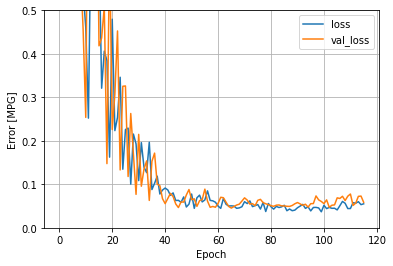

In [17]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.5])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)


Evaluate neural network

In [18]:
results = model0.evaluate(XX_test_n, yy_test_n)

print('loss test data: ', results[0])
print('mse test data: ', results[1])

results = model0.evaluate(XX_train_n, yy_train_n)

print('loss train data: ', results[0])
print('mse train data: ', results[1])

4/4 [==============================] - 0s 2ms/step - loss: 0.0587 - mse: 0.0587
loss test data:  0.058678314089775085
mse test data:  0.058678314089775085
4/4 [==============================] - 0s 2ms/step - loss: 0.0393 - mse: 0.0393
loss train data:  0.03929116576910019
mse train data:  0.03929116576910019


Plot results

<function matplotlib.pyplot.show>

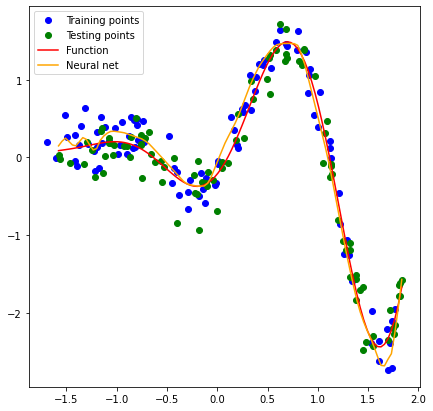

In [19]:
fig = plt.figure(figsize=(7,7))

plt.plot(XX_train_n,yy_train_n, 'o', color='blue', label='Training points')
plt.plot(XX_test_n,yy_test_n, 'o', color='green', label='Testing points')

points = np.linspace(min(XX_test_n), max(XX_test_n),num=100)
plt.plot(points, (funct(points*std+mean)-meany)/stdy,  color='red', label='Function')

plt.plot(points, model0.predict(points),  color='orange', label='Neural net')

#plt.plot(XX_train_n, model0.predict(XX_train_n), 'o',  color='red', label='NN')

plt.legend()


plt.show